In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_theme(rc={'figure.dpi': 72, 'savefig.dpi': 300,
              'figure.autolayout': True})
sns.set_style('ticks')
sns.set_context('paper')

df = pd.read_csv('data/emails.csv')
y = df['spam']
x = df['text']
y = y == 1

In [2]:
def split_data(x, y, test_size):
    tslen = int(test_size * len(x))
    p = np.random.permutation(len(x))
    x, y = x.iloc[p], y.iloc[p]
    x_test = x.iloc[:tslen]
    x_train = x.iloc[tslen:]
    y_test = y.iloc[:tslen]
    y_train = y.iloc[tslen:]
    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = split_data(x, y, test_size=0.20)

In [3]:
import nltk
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
allwords = nltk.corpus.words.words()
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Reza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Reza\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Reza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def fetch_words(ctx):
    ctx = ctx.lower()
    words = nltk.tokenize.word_tokenize(ctx)
    words = [w for w in words if len(w) > 1]  # skip absurd words
    words = [w for w in words if w not in stopwords]  # skip stop words
    words = [w for w in words if w in allwords]  # skip non-english words
    words = [nltk.stem.PorterStemmer().stem(w) for w in words]  # stem
    words = set(words)
    return words


def count_words(x):
    wcnt = {}
    for ctx in x:
        words = fetch_words(ctx)
        for w in words:
            wcnt.setdefault(w, 0)
            wcnt[w] += 1
    return wcnt

In [5]:
import pickle
import os

# Save preprocessed data, because the preprocessing phase takes much time.
if not os.path.exists('temp'):
    sw_train = count_words(x_train[y_train])
    hw_train = count_words(x_train[~y_train])
    with open('temp', 'wb') as f:
        pickle.dump([sw_train, hw_train, x_train, x_test, y_train, y_test], f)

# Load preprocessed data.
if os.path.exists('temp'):
    with open('temp', 'rb') as f:
        sw_train, hw_train, x_train, x_test, y_train, y_test = pickle.load(f)

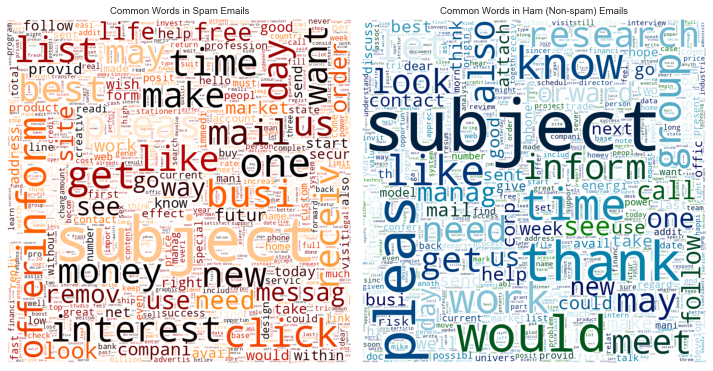

In [49]:
# Visualize the most common words in spam emails.
spam_img = WordCloud(width=720, height=720, max_words=2000,
                     colormap='gist_heat', background_color='white')
spam_img.generate_from_frequencies(sw_train)

# Visualize the most common words in ham (non-spam) emails.
ham_img = WordCloud(width=720, height=720, max_words=2000,
                    colormap='ocean', background_color='white')
ham_img.generate_from_frequencies(hw_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 5.5))
ax[0].imshow(spam_img)
ax[0].axis('off')
ax[0].set_title("Common Words in Spam Emails")
ax[1].imshow(ham_img)
ax[1].axis('off')
ax[1].set_title("Common Words in Ham (Non-spam) Emails")
fig.savefig('P3_a.png')
plt.show()

In [35]:
def check_spam(ctx: str, spam_words: dict, ham_words: dict, s: int = 100, p: float = 0.85) -> bool:
    """Implementation of Naive Bayes Algorithm for Spam Detection
    Tip: Tune s and p parameters for imbalanced data sets.

    Args:
        ctx (str): Context of the email/message.
        spam_words (dict): Spam words with their counts.
        ham_words (dict): Ham words with their counts.
        s (int, optional): Given strength about incoming spam. Defaults to 100.
        p (float, optional): Probability of email to be spam. Defaults to 0.85.

    Returns:
        bool: prediction (True: spam, False: ham/non-spam)
    """
    n = 0
    words = fetch_words(ctx)
    for w in words:
        spam_cnt = spam_words.get(w, 0)
        ham_cnt = ham_words.get(w, 0)
        total_cnt = spam_cnt + ham_cnt

        if total_cnt == 0:
            continue

        spam_p = spam_cnt / total_cnt
        ham_p = ham_cnt / total_cnt
        total_p = spam_p + ham_p

        if total_p == 0:
            continue

        sp = spam_p / total_p
        sc = (s * p + total_cnt * sp) / (s + total_cnt)
        n += np.log(1 - sc) - np.log(sc)
    result = 1 / (1 + np.e ** n)
    return result > (1 - p)


def predict(x, spam_words, ham_words):
    y_pred = [check_spam(ctx, spam_words, ham_words) for ctx in x]
    return np.array(y_pred)


y_pred = predict(x_test, sw_train, hw_train)


In [36]:
def evaluate(y_true, y_pred):
    TP = np.sum(y_true & y_pred)
    TN = np.sum(~y_true & ~y_pred)
    FP = np.sum(~y_true & y_pred)
    FN = np.sum(y_true & ~y_pred)

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    F1 = 2 * precision * TPR / (precision + TPR)

    print('TP:', TP)
    print('TN:', TN)
    print('FP:', FP)
    print('FN:', FN)
    print('Accuracy:', round(accuracy, 4))
    print('F1-score:', round(F1, 4))
    print('Precision:', round(precision, 4))
    print('TPR (Recall, Sensitivity):', round(TPR, 4))
    print('TNR (Specificity):', round(TNR, 4))


evaluate(y_test, y_pred)

TP: 244
TN: 790
FP: 79
FN: 32
Accuracy: 0.9031
F1-score: 0.8147
Precision: 0.7554
TPR (Recall, Sensitivity): 0.8841
TNR (Specificity): 0.9091
